In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/train.csv')
train_df

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,neutral,Relationship status.\nSingle\nMarried\nIt's co...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,neutral,Bernie or REAGAN?\nBe informed. Compare them o...
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,positive,I HEAR SOMETHING\nBetter run a mile\nOMG RAJ?\...
3,3,https://preview.redd.it/iwcz3o2niix61.jpg?widt...,very_funny,twisted_meaning,not_offensive,not_motivational,positive,Redditors Visiting IG memepages\n*dies from cr...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,not_funny,not_sarcastic,very_offensive,not_motivational,negative,"Samajh nahi aaya Par sun ke acabo,\nBUDGET SPE..."
...,...,...,...,...,...,...,...,...
6995,6995,https://preview.redd.it/3c7iiijlg9d61.jpg?widt...,hilarious,general,slight,not_motivational,negative,$14 y/o nibbi*\n*16 y/o nibba*\n*20 y/o single...
6996,6996,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,very_twisted,hateful_offensive,not_motivational,negative,I DON'T HAVE A PROBLEM WITH\nIMMIGRATION\nIF W...
6997,6997,https://encrypted-tbn0.gstatic.com/images?q=tb...,hilarious,not_sarcastic,not_offensive,not_motivational,positive,"Como umbalin\nHey Alia,\nWhat is the\nOpposite..."
6998,6998,https://encrypted-tbn0.gstatic.com/images?q=tb...,hilarious,general,very_offensive,motivational,negative,baby kya kr rhe ho?\ntumhara favorite football...


In [ ]:
train_df['overall'] = train_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

<ipython-input-4-17c9202b8875>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['overall'] = train_df['overall'].replace({


In [ ]:
print(train_df['overall'].value_counts())

overall
1    2970
2    2275
0    1755
Name: count, dtype: int64


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/val.csv')
val_df

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,RVCJ\nwww.EVCI.COM\nTum paas aaye yun muskuray...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,negative,"rukjao Maqbeol,\nbabuji ko tum nalt muaracay-\..."
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,very_negative,champak appreciating Jetha\nfor following lock...
3,3,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,negative,Noor Malik@ItsNoor 22h\nWhen you realize k\nNa...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,neutral,noop\nαποταθεωρία\nNehe: ita gis having 5 boyf...
...,...,...,...,...,...,...,...,...
1494,1495,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,"CHALATA HOON MAIN WAGONR\nABKI BAAR, MODI SARK..."
1495,1496,https://simg-memechat.s3.ap-south-1.amazonaws....,funny,general,not_offensive,not_motivational,neutral,*Tourist visiting\nAfghanistan\n*Terrorist wel...
1496,1497,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,negative,Pic 1: Lockdown\nkhatam ho gya.. Ab\nPani-Puri...
1497,1498,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,positive,When you're from UP/Bihar\nand select English ...


In [ ]:
val_df['overall'] = val_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

<ipython-input-7-34c074e87179>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['overall'] = val_df['overall'].replace({


In [ ]:
print(val_df['overall'].value_counts())

overall
0    580
1    579
2    340
Name: count, dtype: int64


In [ ]:
!pip install text_hammer

In [ ]:
import text_hammer as th

In [ ]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 1.94 ms


In [ ]:
train_dataset = text_preprocessing(train_df, 'ocr')
val_dataset = text_preprocessing(val_df, 'ocr')a

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

  0%|          | 0/1499 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: Th

Epoch 1/10


100%|██████████| 219/219 [01:58<00:00,  1.85it/s, lr=1e-5, train_loss=1.16]


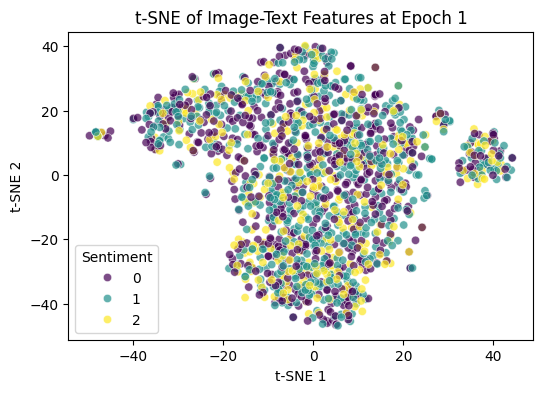

Epoch 2/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:57<00:00,  1.86it/s, lr=1e-5, train_loss=1.11]


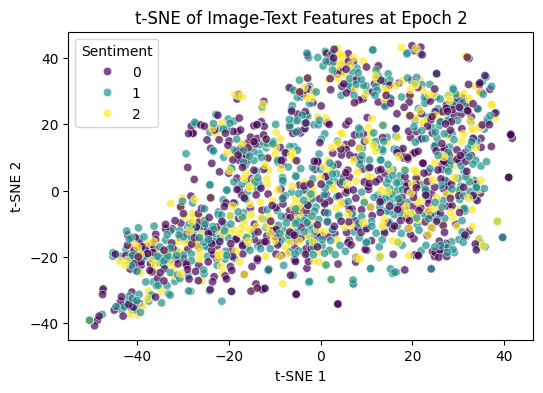

Epoch 3/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.84it/s, lr=1e-5, train_loss=1.06]


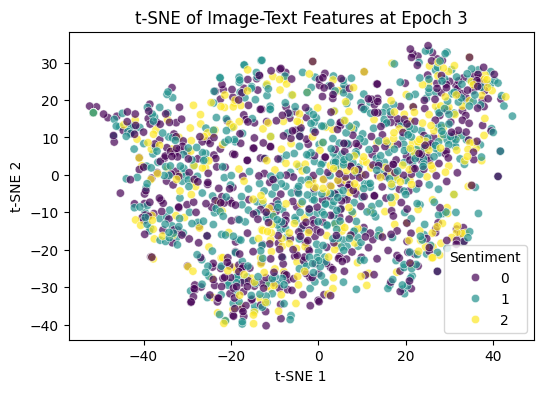

Epoch 4/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.85it/s, lr=1e-5, train_loss=0.995]


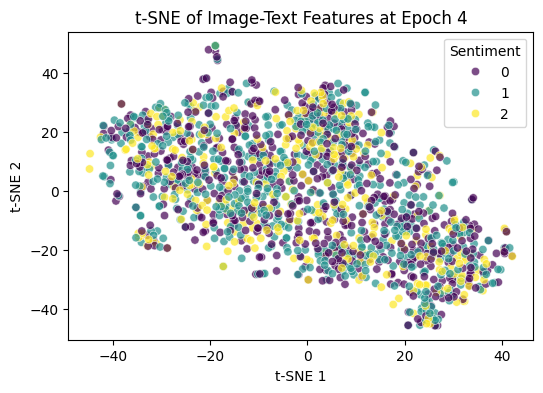

Epoch 5/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.85it/s, lr=1e-5, train_loss=0.846]


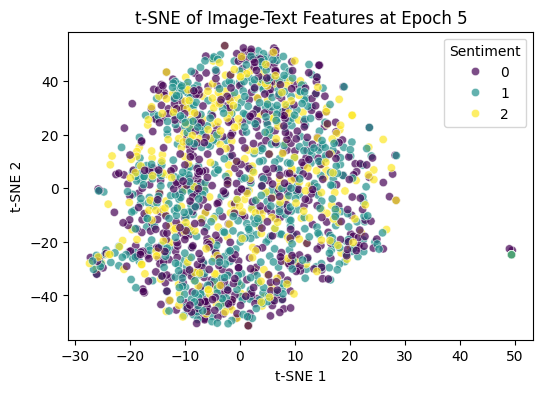

Epoch 6/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [02:00<00:00,  1.82it/s, lr=1e-5, train_loss=0.604]


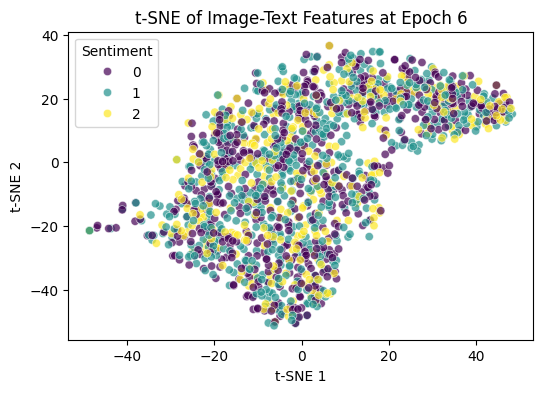

Epoch 7/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.84it/s, lr=1e-5, train_loss=0.387]


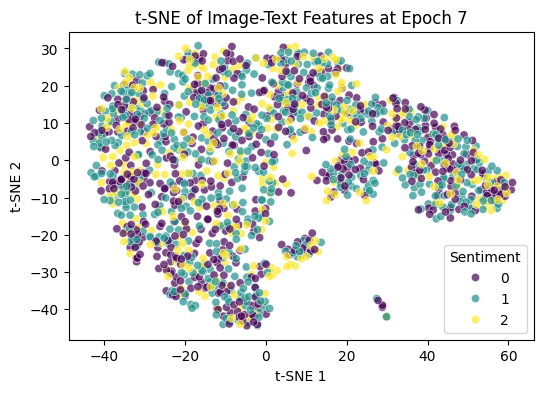

Epoch 8/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.84it/s, lr=1e-5, train_loss=0.273]


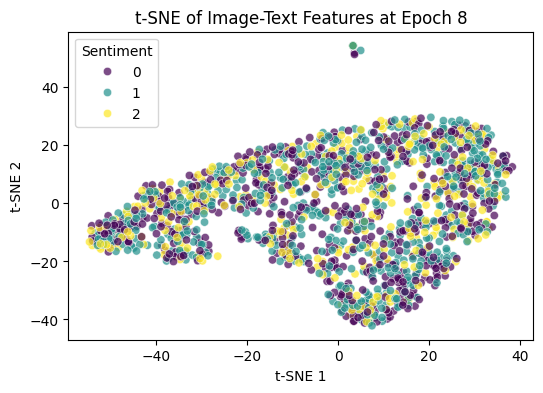

Epoch 9/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.84it/s, lr=1e-5, train_loss=0.205]


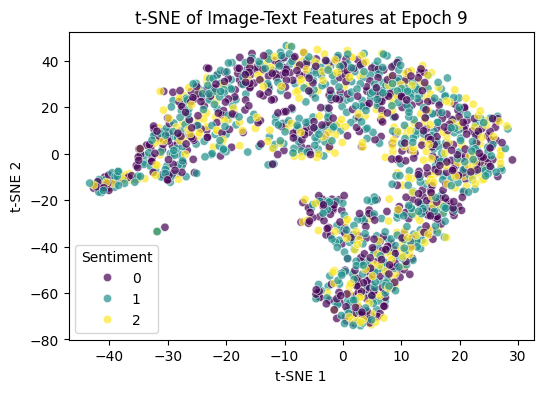

Epoch 10/10


  0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 219/219 [01:58<00:00,  1.84it/s, lr=1e-5, train_loss=0.177]


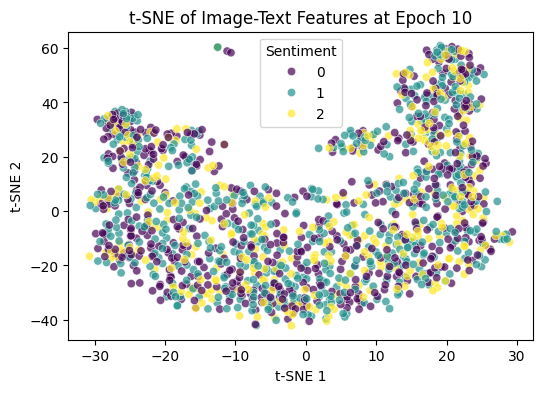

In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        image = cv2.imread(image_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        encoded_caption = self.tokenizer([caption], return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment)
        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask, 'sentiment': sentiment_class}

class CustomCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super(CustomCLIPModel, self).__init__()
        self.clip_model = clip_model
        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.4)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 3)
        self.gelu = nn.GELU()

    def forward(self, image, input_ids, attention_mask):
        text_features = self.clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip_model.get_image_features(pixel_values=image)

        text_features = torch.nn.functional.normalize(text_features, dim=1)
        image_features = torch.nn.functional.normalize(image_features, dim=1)

        combined_features = torch.cat((text_features, image_features), dim=1)
        x = self.fc1(combined_features)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.dropout3(x)
        logits = self.fc4(x)
        return logits, image_features, text_features

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.cross_entropy_loss(logits, labels)
        return ce_loss

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(model, train_loader, optimizer, device, criterion):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()
        logits, image_features, text_features = model(images, input_ids, attention_mask)
        loss = criterion(logits, sentiments)
        loss.backward()
        optimizer.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    accuracy = correct_predictions / total_predictions
    return loss_meter, accuracy


def plot_tsne(image_features, text_features, labels, epoch):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=epoch)  # Adjusted learning rate and initialization
    combined_features = np.concatenate([image_features, text_features], axis=1)
    tsne_results = tsne.fit_transform(combined_features)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=labels, palette="viridis", alpha=0.7
    )
    plt.title(f't-SNE of Image-Text Features at Epoch {epoch}')
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title="Sentiment")
    plt.show()

# Load dataset and initialize data transformations, processor, and model
train_image_dir = '/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/trainImages'
val_image_dir = '/content/drive/MyDrive/Memotion3/drive-download-20240716T190908Z-001/valImages'
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model = CustomCLIPModel(clip_model).to('cuda' if torch.cuda.is_available() else 'cpu')

train_image_transforms = A.Compose([A.Resize(224, 224), A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2),
                                   A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                                   A.CoarseDropout(p=0.2), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

val_image_transforms = A.Compose([A.Resize(224, 224), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

# Prepare DataLoaders
train_dataset = MemeDataset(
    images=train_dataset['image_url'].tolist(),
    captions=train_dataset['ocr'].tolist(),
    sentiments=train_dataset['overall'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_dataset['image_url'].tolist(),
    captions=val_dataset['ocr'].tolist(),
    sentiments=val_dataset['overall'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
criterion = CustomLoss()

# Training Loop
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, device, criterion)

    # t-SNE Visualization
    model.eval()
    image_features = []
    text_features = []
    sentiments = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            _, img_feat, txt_feat = model(images, input_ids, attention_mask)
            image_features.extend(img_feat.cpu().numpy())
            text_features.extend(txt_feat.cpu().numpy())
            sentiments.extend(batch['sentiment'].cpu().numpy())

    plot_tsne(np.array(image_features), np.array(text_features), np.array(sentiments), epoch+1)


In [ ]:
from sklearn.metrics import f1_score, classification_report

val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader,  'cuda' if torch.cuda.is_available() else 'cpu', criterion)

f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')
f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
class_report = classification_report(val_true_labels, val_predictions)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print(f'F1 Weighted: {f1_weighted:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Classification Report:\n{class_report}')

NameError: name 'evaluate' is not defined

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(6,3))
plt.plot(train_accuracies, label='Train Accuracy Curve')
plt.plot(val_accuracies, label='Validation Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(train_losses, label='Train Loss Curve')
plt.plot(val_losses, label='Validation Loss Curve')
plt.legend()
plt.show()